# Encoder - MVP

> Self supervised learning Masked Value Prediction (MVP) as a way to create the embeddings.
Based on tsai's MVP

In [ ]:
from dvats.all import *
from fastcore.all import *
from tsai.all import *
import matplotlib.colors as colors
# try:
#     from tsai.all import *
# except:
#     from tsai.all import * # TODO: Weird error when loading tsai!
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
import wandb
wandb_api = wandb.Api()

In [ ]:
config = AttrDict(
    alias = None, # Alias of the artifact resulting of this run. None will create one automatically
    analysis_mode = 'offline', # 'online' if the model will be tested on future data, or 'offline' if not
    batch_size = 16,
    epochs = 50,
    mask_future = False, # Mask future samples
    mask_stateful = True, # True: mask stateful samples, False: mask individual time steps
    mask_sync = False, # (only for multivariate ts) mask all variables at once
    mvp_ws = (36,72), # Tuple (min_w, max_x) to train MVP with adaptable window sizes. Usually max_w = config.w
    norm_by_sample = False, # Normalize by sample or not
    norm_use_single_batch = False, # Whether to use a single batch or not for the normalization (TSStandardize)
    r = 0.4, # probability of masking in MVP
    stride = 1, # n datapoints the window is moved ahead along the sequence in the sliding window
    train_artifact = 'aida-group/deepvats/synthetic_segmentation:all', # entity/project/name:version
    use_wandb = False, # Whether to use or not wandb for experiment tracking
    valid_size = 0.2, # This will set the percentage of items that go to val
    w = 72, # window size for the sliding window (taxi=48, steamflow=640)
    wandb_group = None # Whether to group this run in a wandb group
)

In [ ]:
#hide
run = wandb.init(entity = os.environ['WANDB_ENTITY'],
                      # work-nbs is a place to log draft runs
                      project=os.environ['WANDB_PROJECT'] if config.use_wandb else 'work-nbs',
                      group=config.wandb_group,
                      job_type='encoder_MVP',
                      allow_val_change=True,
                      mode='online' if config.use_wandb else 'disabled', # Need to be always online to download artifacts
                      config=config,
                      # When use_wandb is false the run is not linked to a personal account
                      #NOTE: This is not working right now
                      anonymous = 'never' if config.use_wandb else 'must',
                      resume=False)
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

In [ ]:
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])

In [ ]:
train_artifact = artifacts_gettr(config.train_artifact)
df_train = train_artifact.to_df()
X_train, _ = sw(df_train)
df_train.shape, X_train.shape

((2016, 1), (1945, 1, 72))

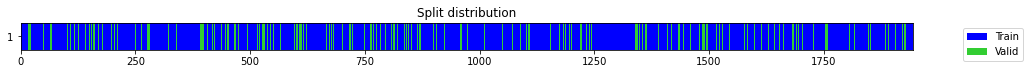

((#1556) [77,1165,1069,1357,1334,884,819,76,1248,245...],
 (#389) [280,49,150,1841,210,1197,1127,1432,1870,1464...])

In [ ]:
assert config.analysis_mode in ['offline','online'], 'Invalid analysis mode'

X = X_train

if config.analysis_mode == 'online':
    splits = TimeSplitter(valid_size=0.2, show_plot=True)(X)
    
elif config.analysis_mode == 'offline':
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size)
    
splits

Train MVP with optional adaptable window sizes, to allow for inference with different
window sizes, to provide an easier exploration of the embedding space through different
ways of sliding the data.

In [ ]:
cbs = L(WandbCallback(log_preds=False)) if config.use_wandb else L()

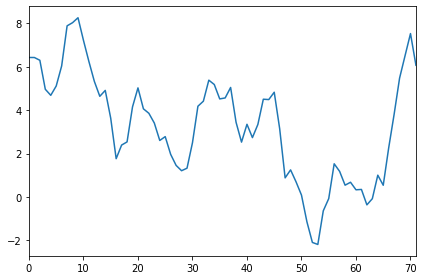

In [ ]:
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=config.norm_by_sample, 
               use_single_batch=config.norm_use_single_batch)]
dls = get_ts_dls(X, splits=splits, tfms=tfms, 
                 bs=config.batch_size, batch_tfms=batch_tfms)
dls.show_at(0)

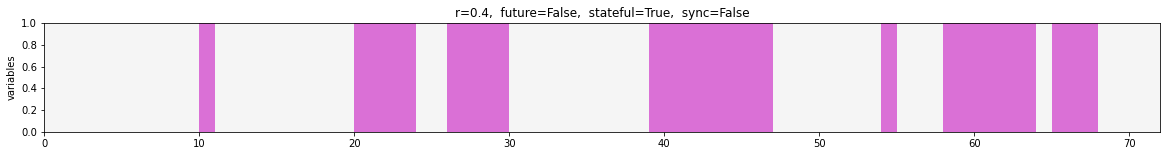

In [ ]:
# example mask
if config.mask_future:
    example_mask = create_future_mask(torch.from_numpy(X[0]), config.r, sync=config.mask_sync)
else:
    example_mask = create_subsequence_mask(torch.from_numpy(X[0]), config.r, stateful=config.mask_stateful, sync=config.mask_sync)
    
fig, ax = plt.subplots(figsize=(20, 2))
plt.pcolormesh(example_mask[0], cmap=colors.ListedColormap(['whitesmoke', 'orchid']))
plt.title(f'r={config.r},  future={config.mask_future},  stateful={config.mask_stateful},  sync={config.mask_sync}')
ax.set_ylabel('variables')
plt.show()

epoch,train_loss,valid_loss,time
0,0.288221,0.212611,00:01
1,0.224407,0.159094,00:01
2,0.187463,0.159784,00:01
3,0.176150,0.177475,00:01
4,0.154543,0.155913,00:01
5,0.131048,0.118127,00:01
6,0.125319,0.130440,00:01
7,0.115868,0.113219,00:01
8,0.124114,0.116685,00:01
9,0.105800,0.084343,00:01


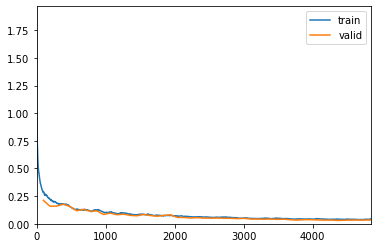


epochs: 50 best epoch:  44  val_loss: 0.030349 - pretrained weights_path='models/encoder_MVP.pth'



[2.9503180980682373]
not enough values to plot a chart


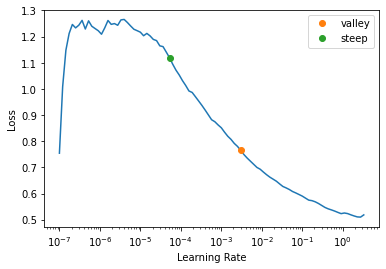

In [ ]:
learn = ts_learner(dls, InceptionTimePlus, 
                   cbs= cbs + ShowGraphCallback() + MVP(r = config.r, 
                   window_size=config.mvp_ws, future_mask = config.mask_future, 
                   target_dir='./models', sync = config.mask_sync, stateful = config.mask_stateful,
                   fname=f'encoder_MVP'), y_range=[X.min(), X.max()])
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))
learn.fit_one_cycle(n_epoch=config.epochs, lr_max=lr_valley)
print(learn.validate())
learn.plot_metrics()

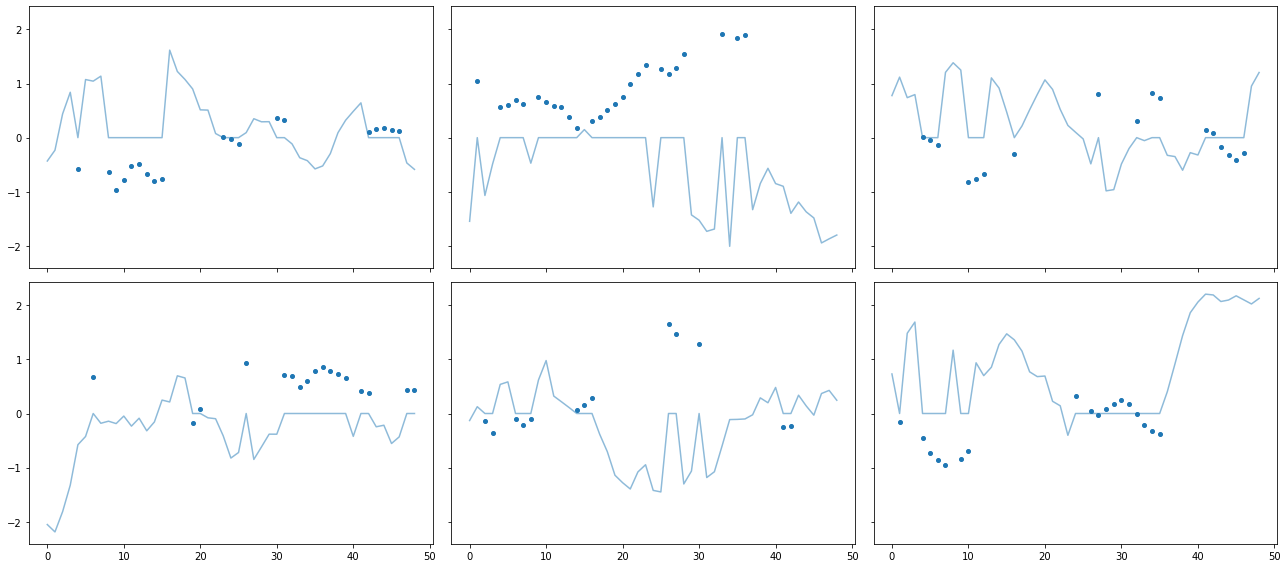

In [ ]:
learn.MVP.show_preds(sharey=True, nrows=2) # error with nwors=1 or ncols=1

In [ ]:
# Log the learner without the datasets
aux_learn = learn.export_and_get()
if config.use_wandb: run.log_artifact(ReferenceArtifact(aux_learn, f'mvp', type='learner', metadata=dict(run.config)), 
                                      aliases=config.alias)

In [ ]:
run.finish()